In [2]:
import warnings
warnings.filterwarnings("ignore")

# Ensemble Learning and Random Forests

### Voting Classifiers
<img src="./pic/hard-voting-classifier-predictions.png" height="300" width="400" align="left"></img>

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [13]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators = [("lr",log_clf),("rf",rnd_clf),("svc",svm_clf)],
    voting='hard'
)

In [14]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomFore...rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [15]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__,accuracy_score(y_test,y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


### Bagging and Pasting
###### 目的：减少basis
###### 不同于上述使用不同算法训练一个数据集投票，这里使用的是同样的方法但是通过不同的随机子集进行训练。对于又放回的采样叫做 Bagging；无放回的采样叫做Pasting
<img src="./pic/bp-training-set-sampling-training.png" width=400 height=300/>

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
# 使用 bagging 时候bootstrap= True,使用 pasting 时候bootstrap= false,n_jobs表示使用的 CPU 的
#核数（-1表示使用所有核数）
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100,bootstrap=True,n_jobs=-1
)
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.92000000000000004

###### out-of-bag(oob)未采样到的，它可以用来评估，而不需要再拆分出一个验证集合

In [20]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100,bootstrap=True,n_jobs=-1,oob_score=True
)
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.92000000000000004

In [24]:
bag_clf.oob_decision_function_[0:10]

array([[ 0.34010152,  0.65989848],
       [ 0.41909814,  0.58090186],
       [ 0.9974359 ,  0.0025641 ],
       [ 0.01333333,  0.98666667],
       [ 0.032     ,  0.968     ],
       [ 0.13020833,  0.86979167],
       [ 0.3740458 ,  0.6259542 ],
       [ 0.0952381 ,  0.9047619 ],
       [ 0.95225464,  0.04774536],
       [ 0.82228117,  0.17771883]])

### Random Patches and Random Subspaces
###### BaggingClassifier支持对特征采样（由max_features 和 bootstrap_features 参数控制，等同于 max_sampels 和 bootstrap），对于高纬度输入很有用。
###### 同时采样训练实例和特征叫做Random Patches
###### 保持所有实例样本采样特征（ max_features小于0，bootstrap_features=True）叫做Random Subspaces

### Random Forests
###### 随机森林是通过 bagging方法集合决策树的训练方法生成的。可以通过 BaggingClassifier和DecisionTreeClassifier组合生成，如上述代码。

In [25]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1,max_leaf_nodes=16)
rnd_clf.fit(X_train,y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test,y_pred_rf)

0.92000000000000004

### Feature Importance
###### 在决策树中，重要的特征一般都在树的顶部，不重要的特征都在叶子节点或是根本就没有切分，

In [26]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])
for name,score in zip(iris['feature_names'],rnd_clf.feature_importances_):
    print(name,score)



sepal length (cm) 0.123381341519
sepal width (cm) 0.0297466760003
petal length (cm) 0.3980920159
petal width (cm) 0.44877996658


### Boosting
###### 有顺序的训练一组预测器，每一个都是纠正它之前的训练器。如 AdaBoost 和 Giandent Boosting。

###### AdaBoost:它是通过纠正它之前预测器预测错的样本，给予更多关注的方法。
<img src="./pic/AdaBoost-weight-updates.png" width=400 height=300/>

###### AdaBoost算法训练过程：
###### 1.初始化样本权重，m 个训练样本
$ W = (w_{1}^{1},w_{1}^{2},...,,w_{1}^m), w_{1}^i=\frac{1}{m},i=1,2,...,m$
###### 2.共进行 M 轮学习，第 j 轮学习过程如下：
###### A）使用权值分布为$W_{j}$的训练样例学习得到基分类器$G_{j}$。
###### B）计算上一步得到的基分类器的误差率：（此公式参考PRML，其余的来自统计学习方法）
第 j个预测器的错误率的权重 $r_{j} = \frac{\sum_{i=1,\hat{y}^i_j\not=y_i}^{m}w^i}{\sum_{i=1}{m}w^i}$
###### C）计算$G_{j}$前面的权重系数：$α_j = η \log{\frac{1-r_j}{r_j}}$,η表示学习率（默认为1），准确率越高的预测器权重越高
###### D） 样本权重$w_j^i$更新规则：i = 1,2,...,m
$$ w^i =\left\{
\begin{array}{rcl}
w^i      &     if \hat{y_j^i}=y^i \\
w^i\exp{α_j}  & if \hat{y_j^i}\not=y^i
\end{array} \right. $$
所有样例权重归一化处理,$\frac{w^i}{\sum_{i=1}^mw^i}$
###### E） 重复 A 到 D
###### F）  算法停止于分类器数量到达设定上限，或是找到一个完美的分类器

###### AdaBoost算法预测过程：计算所有预测器的预测值和他们权重的加权值，对最大的进行投票
$\hat{y}(x) = argmax_{k}\sum_{j=1,\hat{y}_j(x)=k}^{N}α_{j}$,N表示预测器的个数

In [62]:
#scikit-learn 使用的是 SAMME的一个多分类版本（使用多分类指数损失函数进行迭加建模），当
#使用二分类的时候就是 AdaBoost。如果预测器估计类的时候有概率（predict_proba）,
#可以使用 SAMME的变体 SAMME.R 的方法（R 表示 Real）
from sklearn.ensemble import AdaBoostClassifier
#若过拟合可以考虑减少评估器的个数或是使用更强的正则化
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),n_estimators=100,
    algorithm="SAMME.R",learning_rate=0.5
)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=100, random_state=None)

In [63]:
y_pred_rf = ada_clf.predict(X_test)
accuracy_score(y_test,y_pred_rf)

0.91200000000000003

###### Gradient Boosting：不同于 AdaBoost 调整样本的权重，它在前面训练器的残差的基础上努力训练一个新的预测器。（Gradient Boosting Tree）

In [76]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [77]:
from sklearn.tree import DecisionTreeRegressor
#stage-1
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [78]:
#stage-2
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [79]:
#stage-3
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [80]:
X_new = np.array([[0.8]])

In [81]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1,tree_reg2,tree_reg3))

In [82]:
y_pred

array([ 0.75026781])

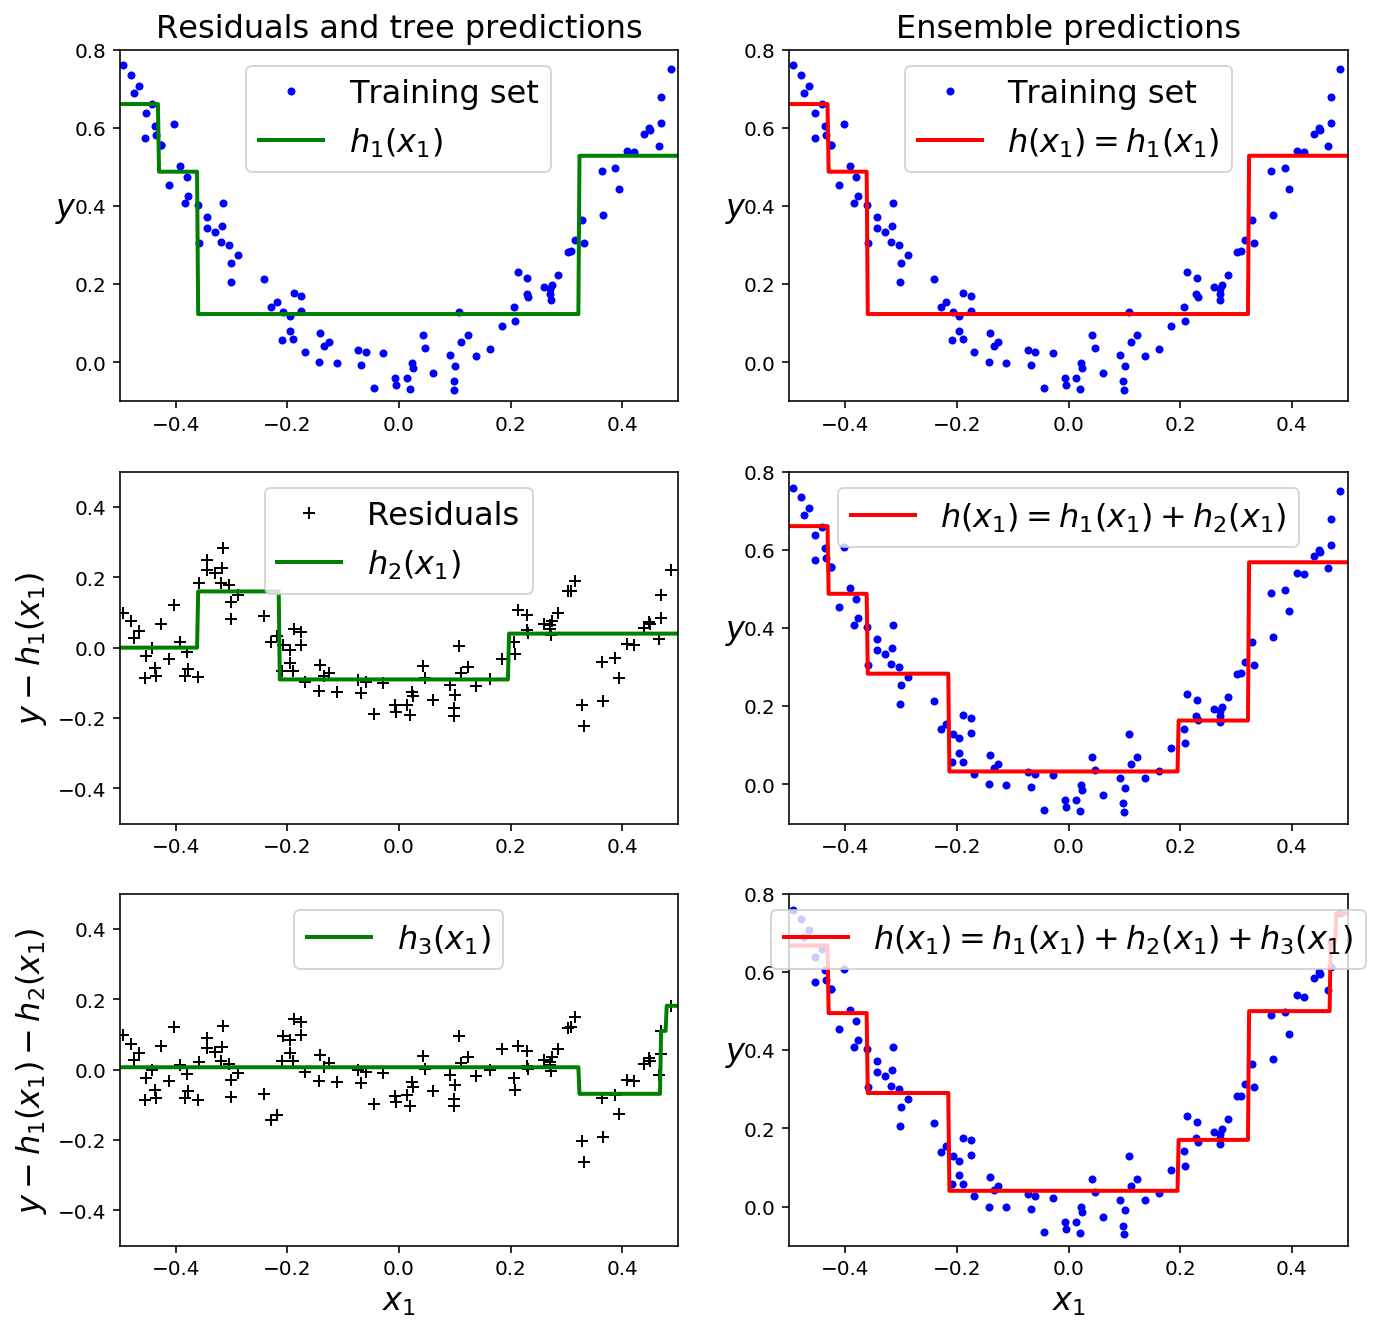

In [84]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

In [88]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

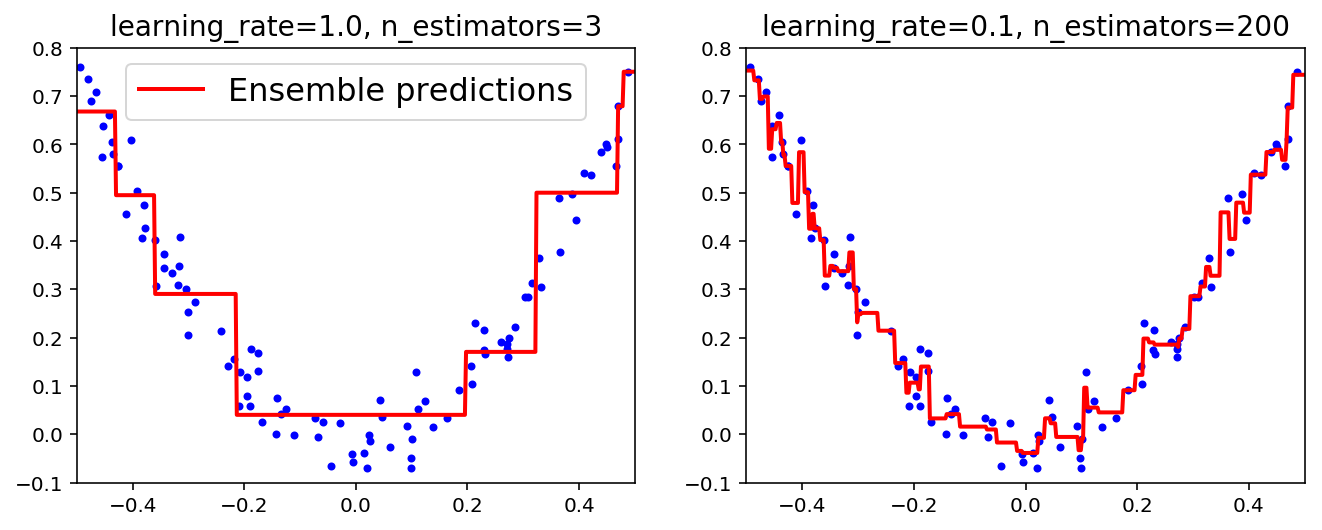

In [89]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train,X_val,y_train,y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)
#staged_predict返回一个遍历所有 gbdt上所有树的预测器的迭代器
errors = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

y_val_pred = gbrt_best.predict(X_val)
mean_squared_error(y_val,y_val_pred)

0.0027672969743513039

In [91]:
gbrt_best

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=84, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

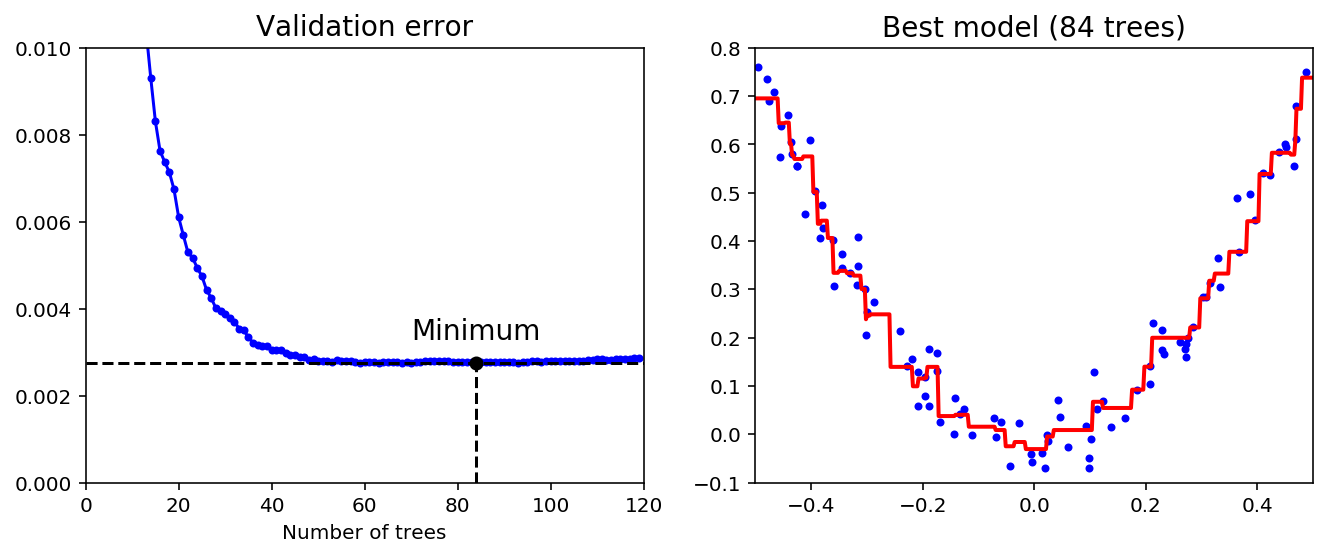

In [93]:
min_error = np.min(errors)
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

In [97]:
a=float("inf")
type(a)

float

In [98]:
# 另一种探测提前停的方法，warm_start=True,它会保存存在的树

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0 
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break
gbrt

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=69, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=True)

### Stacking
###### 不同于使用简单函数（硬投票）来聚合预测器的结果，而是训练一个模型来完成聚合。
<img src=".\pic\Aggregating-predictions-using-blending-predictor.png" width=400 height=300/>

###### 训练过程
1.将训练集合拆分成2份，第一份用来训练第一层的预测器
<img src=".\pic\Training-the-first-layer.png"/>

###### 在第一步训练完成的基础上，把第二份子集在第一层预测的结果作为新的输入特征放到 blender 层去训练
<img src=".\pic\Training-blender-layer.png"/>

###### 附录:还可以训练多个 blender 层
<img src=".\pic\Predictions-in-a-multilayer-stacking-ensemble.png"/>